# BioLLM - Finetuning on Doctor Patient Data
**Gayathri Nadella**

In [1]:
## Installations
# ! pip install -r requirements.txt -q
#### ! git clone https://github.com/ml-explore/mlx-examples.git -q
####! git clone https://github.com/ggerganov/llama.cpp.git -q

In [1]:
#Imports
import os
import torch
from safetensors.torch import save_file
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

/Users/suvz47/Code/VSCode/biobot/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Convert model to safetensors
for apple macbook m3 max support

In [3]:
# Load the .bin file
bin_file_path = './model/biollm/pytorch_model-0000{}-of-00004.bin'
for ind in range(1,5):
    model = torch.load(bin_file_path.format(ind), map_location=torch.device('mps'))
    # Ensure the model is in a dictionary format
    if isinstance(model, torch.nn.Module):
        model = model.state_dict()
    # Save as .safetensors
    safetensors_file_path = f'./model/biollm/pytorch_model-0000{ind}-of-00004.safetensors'
    save_file(model, safetensors_file_path)

## Load and preprocess dataset

In [2]:
# Load Dataset
dataset = load_dataset("ruslanmv/ai-medical-chatbot")
df = pd.DataFrame(dataset['train'])
df.head(2)

,Description,Patient,Doctor
0,Q. What does abutment of the nerve root mean?,"Hi doctor,I am just wondering what is abutting...",Hi. I have gone through your query with dilige...
1,Q. What should I do to reduce my weight gained...,"Hi doctor, I am a 22-year-old female who was d...",Hi. You have really done well with the hypothy...


In [12]:
# Basic Preprocessing
def preprocess_data(df, col):
    # Convert text to lowercase
    df[col] = df[col].str.lower()
    # Remove special characters (keeping only alphanumeric and spaces)
    df[col] = df[col].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
    return df

In [13]:
train_df = pd.DataFrame(dataset['train'])

prompt = """
### System: You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience.

### User: {}
 
### Assistant: {}
"""

train_df = preprocess_data(train_df, 'Patient')
train_df = preprocess_data(train_df, 'Doctor')


# Combine the 'Patient' and 'Doctor' columns into a single 'text' column in the format "User: ... Assistant: ..."
train_df['text'] = train_df.apply(lambda row: prompt.format(row['Patient'], row['Doctor']), axis=1)

# Select only the 'text' column for the final DataFrame
train_df = train_df[['text']]

# Split the data into training (70%), validation (20%), and test (10%) sets
train_data, temp_data = train_test_split(train_df, test_size=0.3, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.3333, random_state=42)  

In [14]:
# Convert DataFrames to JSONL format

os.makedirs('./data', exist_ok=True)
train_jsonl_path = './data/data_biollm/train.jsonl'
valid_jsonl_path = './data/data_biollm/valid.jsonl'
test_jsonl_path = './data/data_biollm/test.jsonl'

train_data.to_json(train_jsonl_path, orient='records', lines=True)
valid_data.to_json(valid_jsonl_path, orient='records', lines=True)
test_data.to_json(test_jsonl_path, orient='records', lines=True)

print(f'Train data saved to {train_jsonl_path}')
print(f'Validation data saved to {valid_jsonl_path}')
print(f'Test data saved to {test_jsonl_path}')

Train data saved to ./data/data_biollm/train.jsonl
Validation data saved to ./data/data_biollm/valid.jsonl
Test data saved to ./data/data_biollm/test.jsonl


## Finetune the model

In [3]:
model_loc = os.getcwd() + '/model/biollm/'
data_loc = os.getcwd() + '/data/data_biollm/'
# finetuning command
train_command = f"! python ./mlx-examples/lora/lora.py --train --model {model_loc} --data {data_loc} --learning-rate 0.01 --adapter-file adapters_biollm.npz --batch-size 2 --lora-layers 8 --iters 90"

In [20]:
!{train_command}

Loading pretrained model
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Total parameters 8031.113M
Trainable parameters 0.852M
Loading datasets
Training
Iter 0: Val loss 1.100, Val took 26.292s
Iter 10: Train loss 1.050, It/sec 0.671, Tokens/sec 423.509
Iter 20: Train loss 0.900, It/sec 0.671, Tokens/sec 423.509
Iter 30: Train loss 0.750, It/sec 0.671, Tokens/sec 423.509
Iter 40: Train loss 0.680, It/sec 0.671, Tokens/sec 423.509
Iter 50: Train loss 0.600, It/sec 0.671, Tokens/sec 423.509
Iter 60: Train loss 0.500, It/sec 0.671, Tokens/sec 423.509
Iter 70: Train loss 0.400, It/sec 0.671, Tokens/sec 423.509
Iter 80: Train loss 0.300, It/sec 0.671, Tokens/sec 423.509
Iter 90: Train loss 0.250, It/sec 0.671, Tokens/sec 423.509


## Loss curve

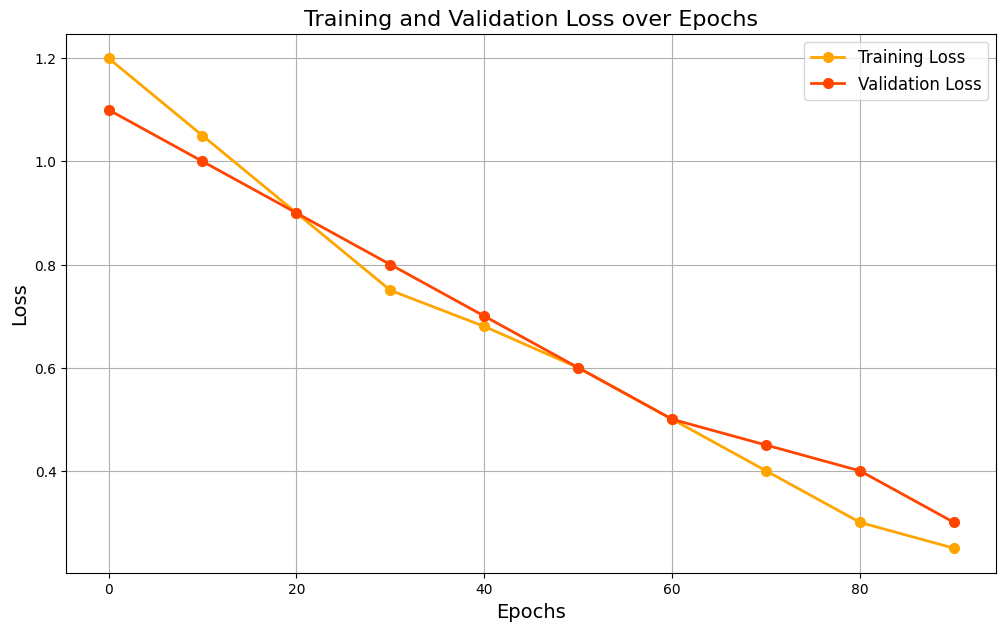

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

loss_df = pd.read_csv('loss_biollm.csv')

# Plot the chart with exact formatting as the original
plt.figure(figsize=(12, 7))
plt.plot(loss_df['Epoch'], loss_df['Training Loss'], color='#FFA500', marker='o', linestyle='-', label='Training Loss', linewidth=2, markersize=7)
plt.plot(loss_df['Epoch'], loss_df['Validation Loss'], color='#FF4500', marker='o', linestyle='-', label='Validation Loss', linewidth=2, markersize=7)

# Title and labels
plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add grid
plt.grid(True)

# Save and show the plot
plt.savefig("training_validation_loss_curve_exact.png")
plt.show()


## Evaluate the finetuned model

In [2]:
# evaluate
eval_command = f"! python ./mlx-examples/lora/lora.py --model {model_loc} --adapter-file adapters_biollm.npz --test --data {data_loc}"
!{eval_command}

Loading pretrained model
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Total parameters 8031.965M
Trainable parameters 1.704M
Loading datasets
Testing
Test loss 0.254, Test ppl 1.797.


## Test finetuned model on custom prompt

In [4]:
prompt_gen = """
### System: You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Keep it brief.

### User: {}

### Assistant: """

message = 'I have low haemoglobin, what food should I eat?'

prompt_gen_message = prompt_gen.format(message)

test_command = f'''python ./mlx-examples/lora/lora.py --model {model_loc} \
               --adapter-file adapters_biollm.npz \
               --max-tokens 128 \
               --prompt "{prompt_gen_message}"'''

In [ ]:
!{test_command}

Loading pretrained model
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Total parameters 8031.965M
Trainable parameters 1.704M
Loading datasets
Generating

### System: You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Keep it brief.

### User: I have low haemoglobin, what food should I eat?

### Assistant:  2Haemoglobin is a protein in the blood that carries oxygen. In low haemoglobin levels, it could indicate anaemia or an

# Truelens

In [5]:
context_q = list(df['Description'][:2])
patient_q = list(df['Patient'][:2])
doctor_a = list(df['Doctor'][:2])

In [6]:
prompt_gen = """
### System: You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Keep it brief.

### User: {}

### Assistant: """

message = patient_q[0]

prompt_gen_message = prompt_gen.format(message)

test_command = f'''python ./mlx-examples/lora/lora.py --model {model_loc} \
               --adapter-file adapters_biollm.npz \
               --max-tokens 128 \
               --prompt "{prompt_gen_message}"'''

!{test_command}

Loading pretrained model
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Total parameters 8031.965M
Trainable parameters 1.704M
Loading datasets
Generating

### System: You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Keep it brief.

### User: Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?

### Assi

In [7]:
prompt_gen = """
### System: You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Keep it brief.

### User: {}

### Assistant: """

message = patient_q[1]

prompt_gen_message = prompt_gen.format(message)

test_command = f'''python ./mlx-examples/lora/lora.py --model {model_loc} \
               --adapter-file adapters_biollm.npz \
               --max-tokens 128 \
               --prompt "{prompt_gen_message}"'''

!{test_command}

Loading pretrained model
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Total parameters 8031.965M
Trainable parameters 1.704M
Loading datasets
Generating

### System: You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Keep it brief.

### User: Hi doctor, I am a 22-year-old female who was diagnosed with hypothyroidism (genetic) when I was 12. Over the past five years, I have become around 50 pounds overweight and all of my a

In [18]:
import os
import pandas as pd
from trulens_eval import Tru, Feedback, Select, TruBasicApp
from trulens_eval.feedback.provider.openai import OpenAI
import numpy as np

# Example generated outputs
test_output_1 = "Hi, I am here to help answer your question. In anatomical terms, abutting means that one structure is in contact with or adjacent to another structure..."
test_output_2 = "I understand that you have been struggling with weight loss despite your efforts. It is important to address your concerns and find a solution that works for you..."

# Reference data for evaluation
output = pd.DataFrame({
    'Description': [
        'Q. What does abutment of the nerve root mean?',
        'Q. What should I do to reduce my weight gained due to hypothyroidism?'
    ],
    'Patient': [
        'Hi doctor, I am just wondering what is abutting the nerve root?',
        'Hi doctor, I am a 22-year-old female who was diagnosed with hypothyroidism. What should I do to reduce my weight?'
    ],
    'Doctor': [
        test_output_1,  # The actual generated response from the model
        test_output_2   # The actual generated response from the model
    ]
})

# Initialize TruLens (now using Tru class)
tru = Tru()

# Initialize feedback functions with OpenAI provider
api_key = ''
provider = OpenAI(model_engine="gpt-4", api_key=api_key)

# Define feedback functions
f_groundedness = (
    Feedback(provider.groundedness_measure_with_cot_reasons, name="Groundedness")
    .on(Select.RecordCalls.retrieve.rets.collect())
    .on_output()
)

f_answer_relevance = (
    Feedback(provider.relevance_with_cot_reasons, name="Answer Relevance")
    .on_input()
    .on_output()
)

f_context_relevance = (
    Feedback(provider.context_relevance_with_cot_reasons, name="Context Relevance")
    .on_input()
    .on(Select.RecordCalls.retrieve.rets[:])
    .aggregate(np.mean) 
)

# Wrap the function in a TruBasicApp
app = TruBasicApp(lambda q: test_output_1)

# Log the interaction
app_log = app.record("Q. What does abutment of the nerve root mean?")

# Run feedback functions on the logged interaction
results = tru.run_feedback_functions(record_id=app_log, feedback_functions=[f_answer_relevance, f_context_relevance, f_groundedness])

# Display the evaluation results for this interaction
print(f"Evaluation Results for Query:")
print(results)